<a href="https://colab.research.google.com/github/davidfague/Computational-Neuroscience-tutorials/blob/main/B3_Rinput_FI_AP_propagation_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuron

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 52.2 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/davidfague/Neural-Modeling.git

Cloning into 'Neural-Modeling'...
remote: Enumerating objects: 2969, done.
remote: Counting objects: 100% (1104/1104), done.
remote: Compressing objects: 100% (411/411), done.
remote: Total 2969 (delta 815), reused 930 (delta 675), pack-reused 1865
Receiving objects: 100% (2969/2969), 33.56 MiB | 24.55 MiB/s, done.
Resolving deltas: 100% (2019/2019), done.


In [3]:
import os
print(os.system('nrnivmodl')) # compile modfiles. Return 0 for success, 1 for failure.

0


In [4]:
%cd Neural-Modeling/scripts/

/content/Neural-Modeling/scripts


In [5]:
import sys
sys.path.append("../")

In [6]:
from Modules.complex_cell import build_L5_cell_ziao

import numpy as np
import os

from neuron import h
h.load_file("stdrun.hoc")

1.0

In [7]:
import importlib
import constants

In [8]:
# Compile and load modfiles
ret_code = os.system(f"nrnivmodl {constants.modfiles_folder}")
if ret_code != 0:
    print(f"Failed to execute nrnivmodl. Return code: {ret_code}")

h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

1.0

In [9]:
cell = build_L5_cell_ziao(constants.complex_cell_folder) # build 4 compartment cell

In [10]:
# # get modfiles from tutorial repo
# !git clone https://github.com/davidfague/Computational-Neuroscience-tutorials.git

# import os
# from os.path import normpath, sep, join

# root = 'Computational-Neuroscience-tutorials'
# folder = 'B3_Rinput_FI_AP_propagation'
# pathlist = normpath(os.getcwd()).split(sep)
# if pathlist[-1] != folder:
#   rootidx = pathlist.index(root) if root in pathlist else -1
#   if rootidx>0:
#     os.chdir(join(sep,*pathlist[:rootidx]))
#   !git clone https://github.com/chenziao/Software_Tutorials_Colab.git
#   os.chdir(join(root,folder))
# print(os.getcwd())
# %ls



In [11]:
axon_diam = cell.axon[0].diam
print(axon_diam)
print(cell.axon[0].L)

14.096628189086916
59.42929458618164


In [12]:
# # extend axon
# # define our axon geometry
# for i in range(10):
# axon = h.Section('axon') # create neuron Section hoc object
# diam = axon_diam # micrometer
# length = 12000 # micrometer
# if i == 0:
#   axon.connect(cell.axon[i])
# axon.pt3dadd(0,0,0,diam) # (x,y,z,diam) add 3d coordinate
# axon.pt3dadd(length,0,0,diam) # (x,y,z,diam)
# print(axon.L)
# print(axon.diam)
# #axon.L = 1000 # micrometer
# #axon.diam = 2 # micrometer
# axon.nseg = 21 # number of evenly-lengthed, computational compartments per section (segments are compartments that divide up the entire section)

## Input Resistance -- A measure of how much Membrane Voltage will change with respect to Current Injection.

Use a negative current injection and Ohm's Law to determine the cell's soma's input resistance.

In [13]:
# create current injection
IC = h.IClamp(cell.soma[0](0.5)) # create hoc current clamp object at the x=0.9 end of the soma
IC.delay = 10.0 # delay in ms
IC.dur = 1000.0 # duration in ms
IC.amp = -1.0 # amplitude in nA

In [14]:
# define simulation parameters
h.tstop = tstop = 2000 # how long to run the simulation in ms
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init = cell.axon[0].e_pas # give v(0) = e_leak


# record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
V_vecs = [] # list of voltage vectors
i_leak_vecs = []

segs = []

#record soma
seg = cell.soma[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

#record main axon
seg = cell.axon[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

# for axon in new_sections:
#   seg = axon(0.5)
#   segs.append(seg)
#   seg_V_vec = h.Vector() # define vector object for recording variable
#   seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
#   V_vecs.append(seg_V_vec)
#   # record leak current
#   seg_i_leak_vec = h.Vector()
#   try:seg_i_leak_vec.record(seg._ref_i_pas)
#   except:seg_i_leak_vec.record(seg._ref_il_hh)
#   i_leak_vecs.append(seg_i_leak_vec)

t_vec = h.Vector() # time vector
t_vec.record(h._ref_t) # record time during simulation

# vc_i_vec = h.Vector() # vector for recording voltage clamp current
# vc_i_vec.record(vc.i)

h.run() # run simulation

0.0

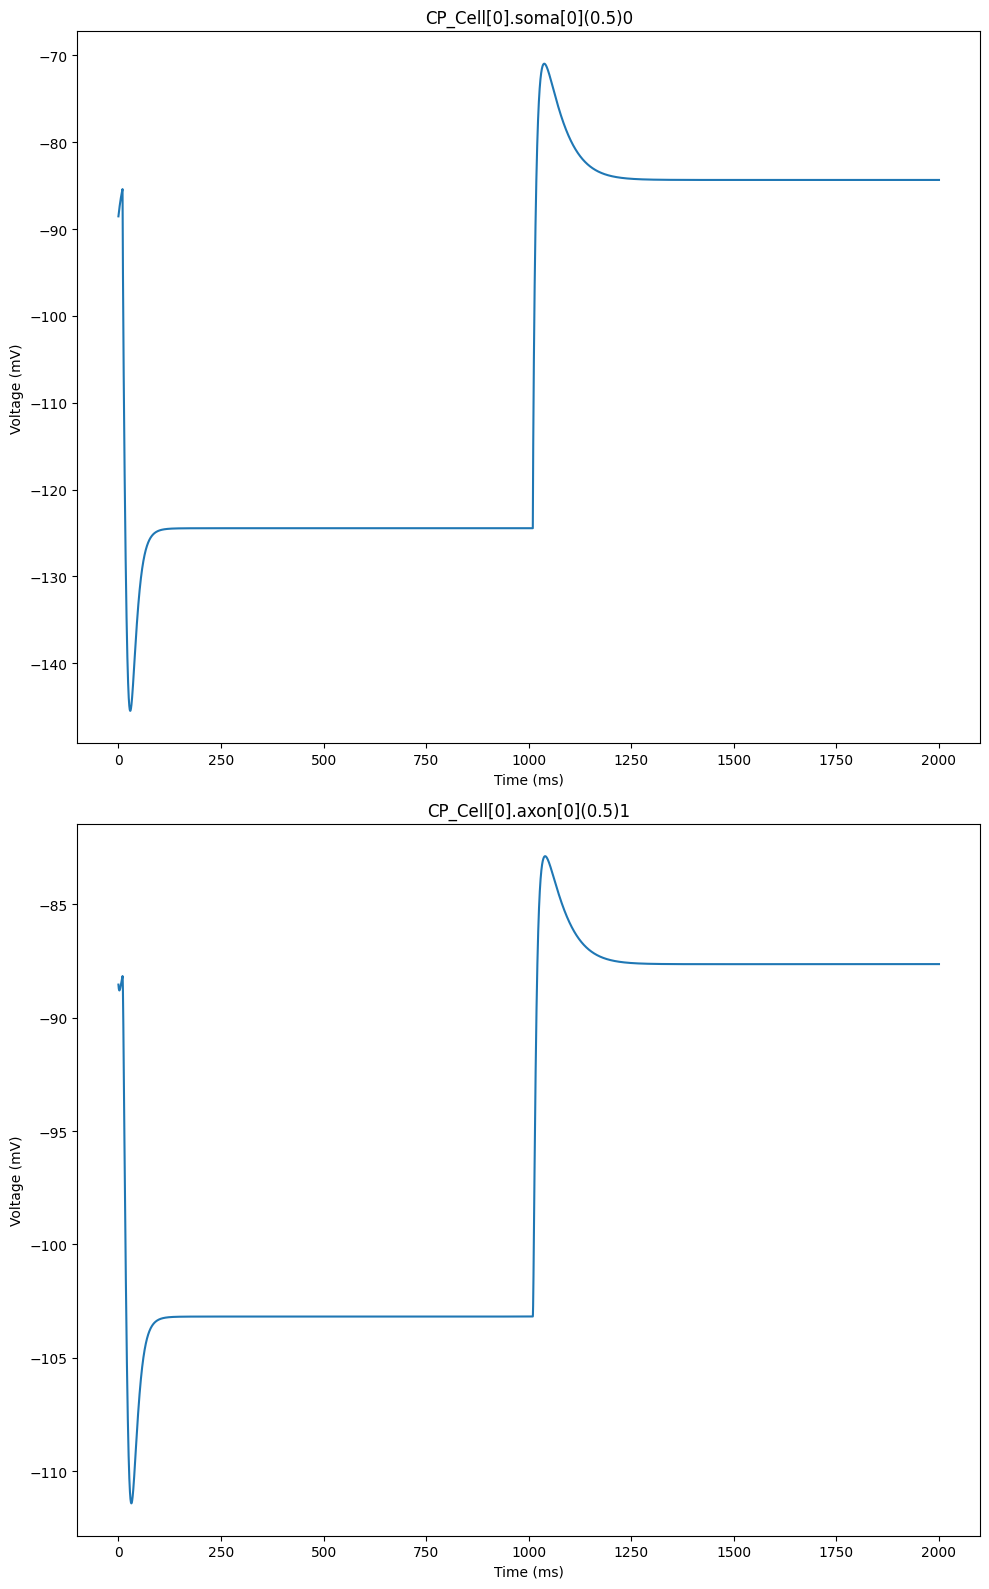

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(segs), 1, figsize=(10, 16))  # 10 subplots stacked vertically, figure size is 10x20 inches

for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(str(seg) + str(i))
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

In [16]:
# Find Resting membrane potential
rest_time = h.tstop - (IC.dur + IC.delay) / 2
# print(rest_time)
rest_time_index = int(rest_time / h.dt)
rest_V_soma = V_vecs[0][rest_time_index]
print(f"rest_V_soma: {rest_V_soma} mV")

# Find Steady state membrane potential during injection
inj_SS_time = (IC.dur + IC.delay) / 2
# print(inj_SS_time)
inj_SS_time_index = int(inj_SS_time / h.dt)
inj_SS_V_soma = V_vecs[0][inj_SS_time_index]
print(f"inj_SS_V_soma: {inj_SS_V_soma} mV")

# Compute input resistance
V_change = inj_SS_V_soma - rest_V_soma
print(f"V_change: {V_change} mV")
print(f"Current Injection Amplitude: {IC.amp} nA")
Input_resistance = V_change / IC.amp
print(f"Input_resistance: {Input_resistance} MOhms")

rest_V_soma: -84.34577003331847 mV
inj_SS_V_soma: -124.45030500486727 mV
V_change: -40.1045349715488 mV
Current Injection Amplitude: -1.0 nA
Input_resistance: 40.1045349715488 MOhms


1.  What is Input Resistance?
2.  Is a cell with higher input resistance or lower input resistance more likely to fire an action potential when current is injected into the soma?
3.  Can the idea of Input Resistance be applied to dendritic compartments?

## F/I Curve

1. Plot the Firing rate of the cell as a function of Current injection.

In [17]:
# # define simulation parameters
# h.tstop = tstop = 2000 # how long to run the simulation in ms
# h.dt = 0.025 # time step (resolution) of the simulation in ms
# h.v_init = cell.axon[0].e_pas # give v(0) = e_leak

# Perform Simulations with varying current injection amplitude

def set_spike_recorder(cell, spike_threshold, seg_to_record='soma') -> None:
    vec = h.Vector()
    if seg_to_record == 'soma':
      nc = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec = cell.soma[0])
    elif seg_to_record == 'axon':
      nc = h.NetCon(cell.axon[0](0.5)._ref_v, None, sec = cell.axon[0])
    else:
      raise(ValueError(f"{seg_to_record} should be 'soma' or 'axon'"))
    nc.threshold = spike_threshold
    nc.record(vec)
    return vec

V_vecs = [] # list of voltage vectors
segs = []

amps = np.arange(-1.0,2.,.25)
spike_arrays = []

for amp in amps:
  IC.amp = amp # amplitude in nA
  # record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
  i_leak_vecs = []


  spikes = set_spike_recorder(cell=cell, spike_threshold = 0)

  #record soma voltage
  seg = cell.soma[0](0.5)
  segs.append(seg)
  seg_V_vec = h.Vector() # define vector object for recording variable
  seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  #V_vecs.append(seg_V_vec)
  # record leak current
  seg_i_leak_vec = h.Vector()
  seg_i_leak_vec.record(seg._ref_i_pas)
  i_leak_vecs.append(seg_i_leak_vec)

  # #record main axon
  # seg = cell.axon[0](0.5)
  # segs.append(seg)
  # seg_V_vec = h.Vector() # define vector object for recording variable
  # seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  # V_vecs.append(seg_V_vec)
  # # record leak current
  # seg_i_leak_vec = h.Vector()
  # seg_i_leak_vec.record(seg._ref_i_pas)
  # i_leak_vecs.append(seg_i_leak_vec)

  t_vec = h.Vector() # time vector
  t_vec.record(h._ref_t) # record time during simulation

  h.run() # run simulation
  V_vecs.append(np.array(seg_V_vec))
  spike_arrays.append(spikes)

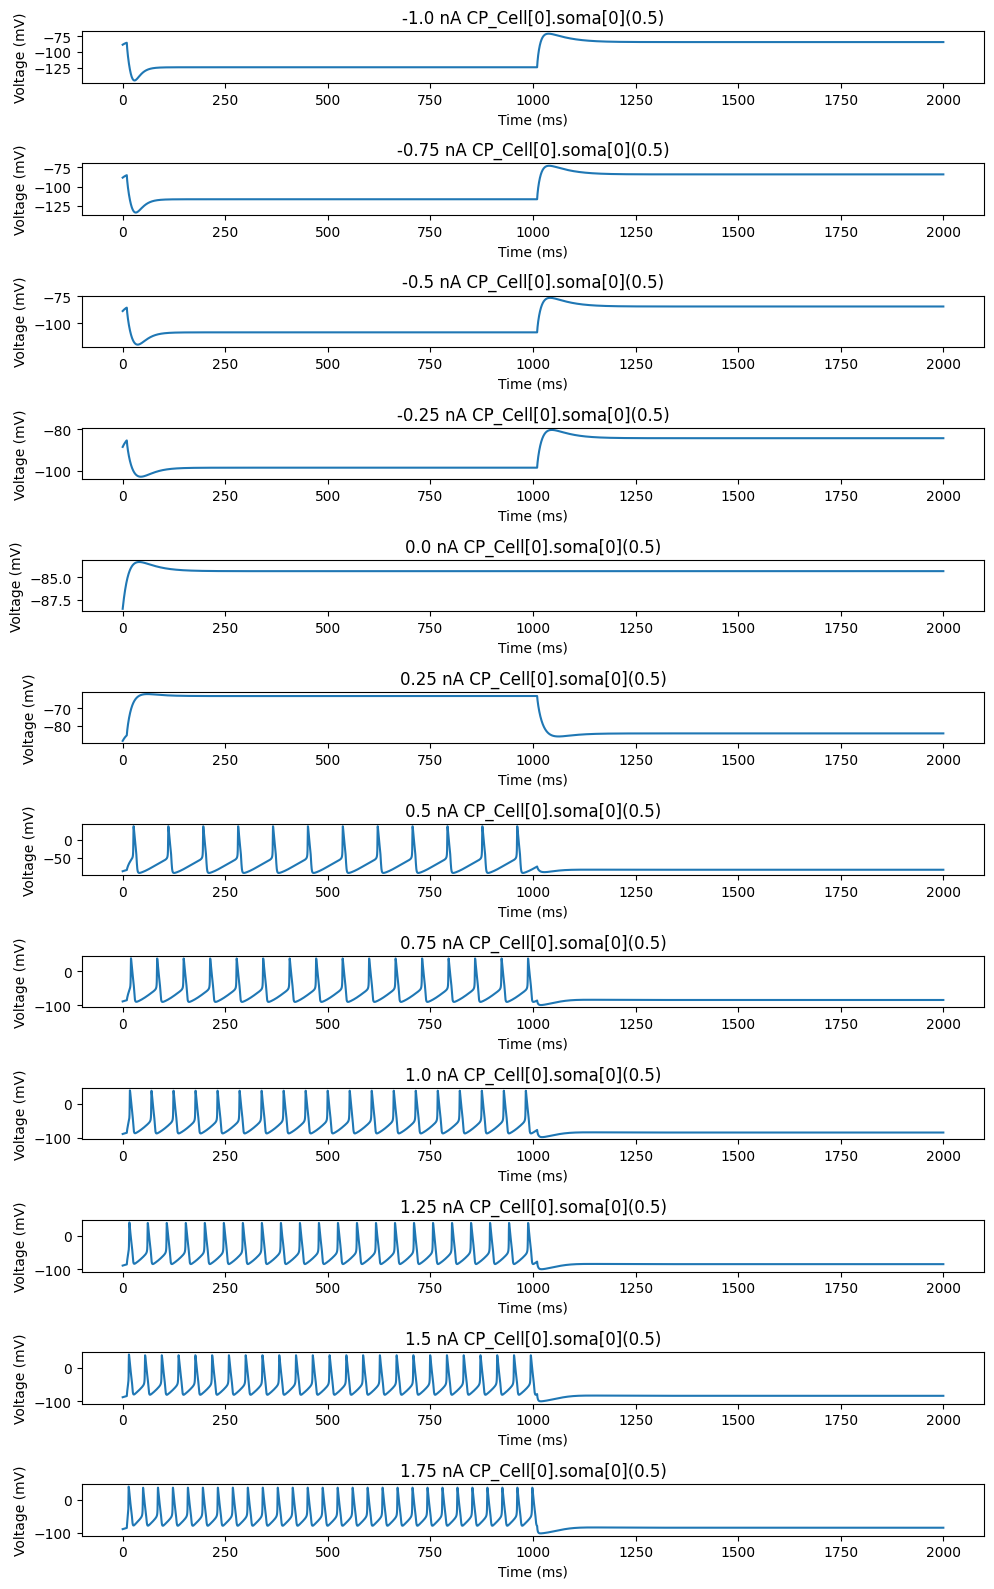

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(segs), 1, figsize=(10, 16))  # 10 subplots stacked vertically, figure size is 10x20 inches

for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(f"{amps[i]} nA {seg}")
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

In [19]:
firing_rates = []
for spike_array in spike_arrays:
  num_spikes = len(spike_array)
  firing_rate = num_spikes / (IC.dur / 1000)
  firing_rates.append(firing_rate)

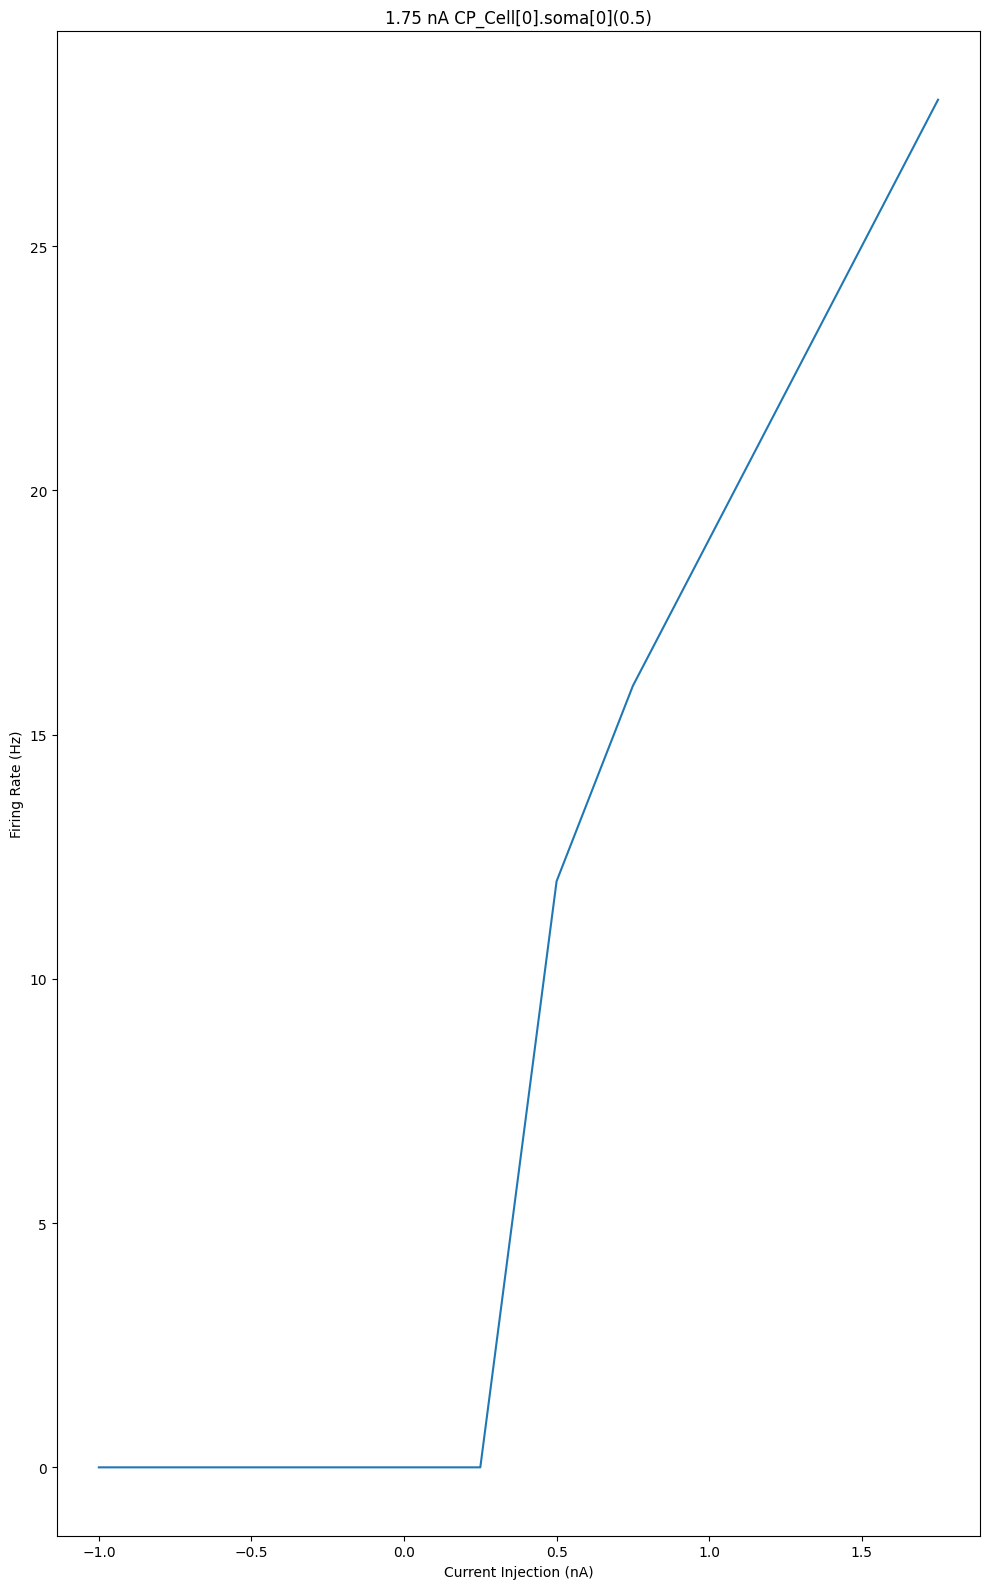

In [20]:
# Plot F/I curve
fig, axs = plt.subplots(1, 1, figsize=(10, 16))  # 10 subplots stacked vertically, figure size is 10x20 inches

axs.plot(amps, firing_rates)
axs.set_title(f"{amps[i]} nA {seg}")
axs.set_xlabel('Current Injection (nA)')
axs.set_ylabel('Firing Rate (Hz)')
  # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

1.   Describe the slope of the line using a piecewise function.

i.e.:

{
  
I <= 0, dFR/dI = 0

I > 0, dFR/dI = 1

}

## Action Potential Propagation

Explore How Nodes of Ranvier and Myelin Sheath allow the Action Potential to reliable travel down the Axon.



1.   Elongate the Axon, adding long myelinated sections sepearted by Nodes of Ranvier. Myelinated sections should have a higher membrane resistance (lower leak conductance), and Nodes should have a higher density of active channels.
2.   Rerun the notebook with each Node of Ranvier's active conductances reduced to 10%. Explain the importance and role of the Nodes.
3.   Fix the previous adjustment. Rerun the notebook after increasing the Myelinated sections' leak conductance to 10 times greater. Explain the importance and role of the Myelin sheath.
4.   Fix the previous adjustment. Rerun the notebook with the next line of code commented. What happens when the axial resistance is higher? Explain How axial resistance affect the propagation of an action potential
5.   To make it easier for a voltage waveform to propagate along a dendrite, should the axial resistance be higher or lower? What about membrane resistance?

In [21]:
cell.axon[0].Ra = cell.axon[0].Ra / 10

In [22]:
# Initial parameters
axon_diam = cell.axon[0].diam#2  # diameter of the axon

# List to hold all axon sections
nodes = []
myelinated_sections = []
new_sections = []

# Define properties for myelinated segments and Nodes of Ranvier
myelin_length = 225#1000
node_length = 1
# myelin_resistance = 1000
# node_resistance = 0.01

for i in range(10):
    if i % 2 == 0:  # Myelinated segment
        axon = h.Section(name='Myelinated[]'.format(i+1))
    else:
        axon = h.Section(name='Node[]'.format(i+1))
    new_sections.append(axon)
    axon.insert('hh')
    #  op0
    axon.cm = cell.axon[0].cm
    for seg in axon:
      seg.hh.el = cell.axon[0](0.5).pas.e
    axon.Ra = cell.axon[0].Ra #/ 3

    # connect to previous section
    if i == 0:
        axon.connect(cell.axon[0](1))
    else:
        axon.connect(new_sections[i-1](1))

    if i % 2 == 0:  # Myelinated segment
        myelinated_sections.append(axon)
        axon.L = myelin_length
        axon.diam = axon_diam
        axon.nseg = 20  # This might vary depending on your requirement
        for seg in axon:
            seg.hh.gl = cell.axon[0](0.5).g_pas / 10000000  # Maximal conductance of K channels
            seg.hh.gkbar =0# 0.036/1000#0.036/10  # Maximal conductance of K channels
            seg.hh.gnabar = 0#0.12/1000  # Maximal conductance of Na channels
        # You might also add other properties specific to myelinated segments

    else:  # Node of Ranvier
        nodes.append(axon)
        axon.L = node_length
        axon.diam = axon_diam

        for seg in axon:
            seg.hh.gl = cell.axon[0](0.5).g_pas / 10 # may update to 80 mS / unit area
            seg.hh.gkbar = 0.036 * 1000  # Maximal conductance of K channels
            seg.hh.gnabar = 0.12 * 500  # Maximal conductance of Na channels

        axon.nseg = 1  # Usually a node of ranvier is represented by one segment

    # Print out some properties for verification
    print("Axon section {}: L = {} um, diam = {} um".format(i, axon.L, axon.diam))


Axon section 0: L = 225.0 um, diam = 14.096628189086916 um
Axon section 1: L = 1.0 um, diam = 14.096628189086916 um
Axon section 2: L = 225.0 um, diam = 14.096628189086916 um
Axon section 3: L = 1.0 um, diam = 14.096628189086916 um
Axon section 4: L = 225.0 um, diam = 14.096628189086916 um
Axon section 5: L = 1.0 um, diam = 14.096628189086916 um
Axon section 6: L = 225.0 um, diam = 14.096628189086916 um
Axon section 7: L = 1.0 um, diam = 14.096628189086916 um
Axon section 8: L = 225.0 um, diam = 14.096628189086916 um
Axon section 9: L = 1.0 um, diam = 14.096628189086916 um


In [23]:
IC.amp = 0.6

In [24]:
# define simulation parameters
h.tstop = tstop = 2000 # how long to run the simulation in ms
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init = cell.axon[0].e_pas # give v(0) = e_leak


# record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
V_vecs = [] # list of voltage vectors
i_leak_vecs = []

segs = []

#record soma
seg = cell.soma[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

#record main axon
seg = cell.axon[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

for axon in new_sections:
  seg = axon(0.5)
  segs.append(seg)
  seg_V_vec = h.Vector() # define vector object for recording variable
  seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  V_vecs.append(seg_V_vec)
  # record leak current
  seg_i_leak_vec = h.Vector()
  try:seg_i_leak_vec.record(seg._ref_i_pas)
  except:seg_i_leak_vec.record(seg._ref_il_hh)
  i_leak_vecs.append(seg_i_leak_vec)

t_vec = h.Vector() # time vector
t_vec.record(h._ref_t) # record time during simulation

# vc_i_vec = h.Vector() # vector for recording voltage clamp current
# vc_i_vec.record(vc.i)

h.run() # run simulation

0.0

In [25]:
# dir(new_sections[0](0.5).hh.il)

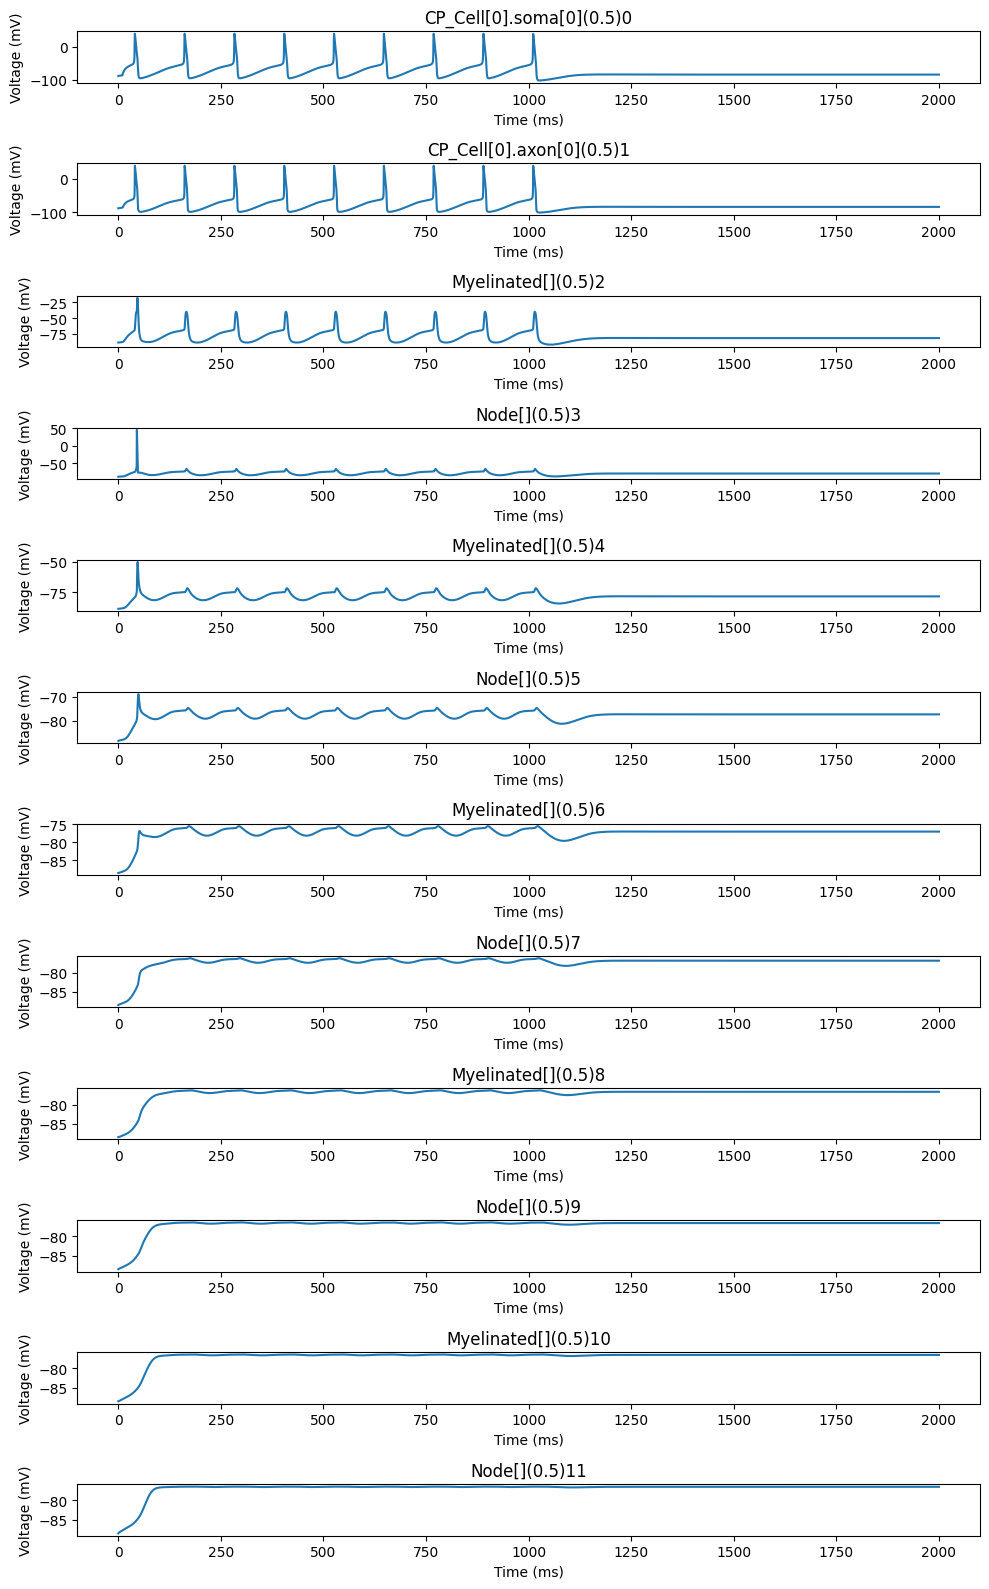

In [26]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(segs), 1, figsize=(10, 16))  # 10 subplots stacked vertically, figure size is 10x20 inches

for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(str(seg) + str(i))
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

TODO: add current injection for single somatic AP, and record AP propagation time with and without myelin sheath. Need to figure out how to get model to behave similarly without myelin sheath.